In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=200):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return history, valid_mae * 1e6

In [3]:
df_og = pd.read_csv('CTA_-_Ridership_-_Daily_Boarding_Totals.csv', parse_dates=['service_date'])

In [4]:
# check which columns of my df_og has how many na

df_og.isna().sum()

service_date      0
day_type          0
bus               0
rail_boardings    0
total_rides       0
dtype: int64

In [5]:
# prompt: check how many duplicate rows in df_og

df_og.duplicated().sum()


62

In [6]:
df=df_og
df.columns = ['date', 'day_type', 'bus', 'rail', 'total']
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1)
df = df.drop_duplicates()

In [7]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


<Axes: xlabel='date'>

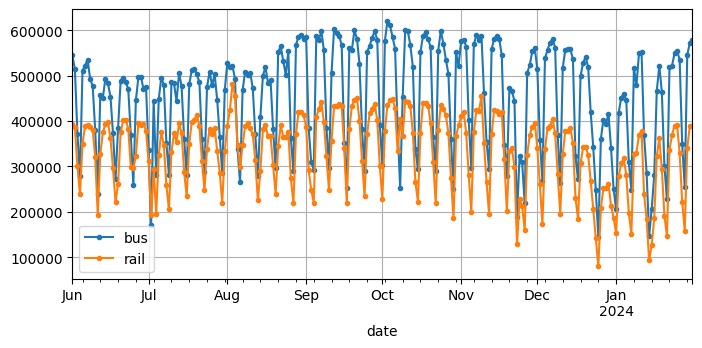

In [8]:
df['2023-06':'2024-01'].plot(grid=True, marker='.', figsize=(8, 3.5))

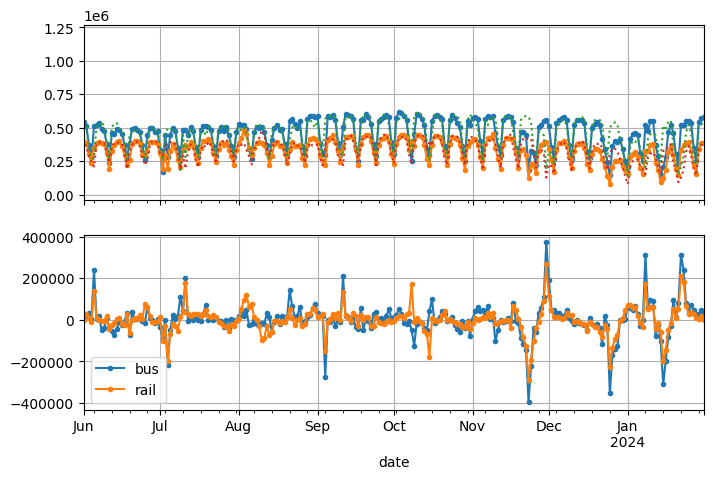

In [9]:
diff_7 = df[['bus', 'rail']].diff(7)['2023-06':'2024-01']

fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker='.')
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':')
diff_7.plot(ax=axs[1], grid=True, marker='.')
fig.show()

In [10]:
diff_7.abs().mean()

bus     47637.697959
rail    38983.795918
dtype: float64

In [11]:
targets = df[['bus', 'rail']]['2023-06':'2024-01']
(diff_7/targets).abs().mean()

bus     0.129436
rail    0.151297
dtype: float64

In [12]:
df1 = df[['bus', 'rail']]

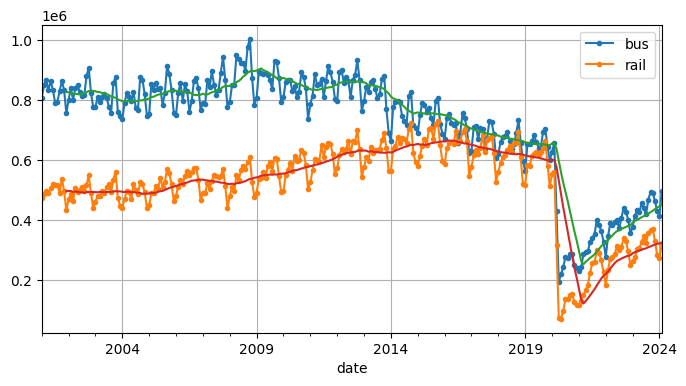

In [13]:
period = slice('2001','2024')
df_monthly = df1.resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
fig.show()

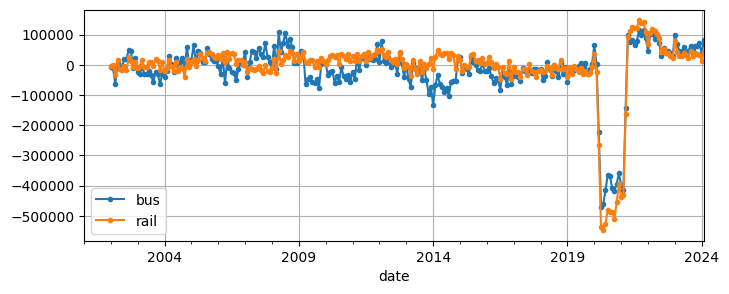

In [14]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8,3))
plt.show()

# The ARMA Model Family
## SARIMA

In [37]:
from statsmodels.tsa.arima.model import  ARIMA

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')

model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))

model = model.fit()
y_pred = model.forecast()

print('The ARIMA model predicts for rail boardings on June 1, 2019 to be approximately:', round(y_pred[0], 0))

The ARIMA model predicts for rail boardings on June 1, 2019 to be approximately: 427759.0


In [38]:
origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'

time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq('D')

y_preds = []

for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], order=(1,0,0), seasonal_order=(0,1,1,7))
    model = model.fit()

    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

print('The MAE score for the ARIMA model on June 1, 2019 to be approximately:', mae)

The MAE score for the ARIMA model on June 1, 2019 to be approximately: 32040.720089453378


# Preparing the Data for Machine Learning Models

In [17]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [40]:
rail_train = df['rail']['2016-01':'2018-12']/1e6
rail_valid = df['rail']['2019-01':'2019-05']/1e6
rail_test = df['rail']['2019-06':]/1e6

In [19]:
seq_length = 56

# Create TensorFlow datasets
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

# Forecasting using a linear model
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

## Forecasting Using a Linear Model

In [20]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

history, valid_mae = fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/200
33/33 [==============================] - 2s 23ms/step - loss: 0.0237 - mae: 0.1653 - val_loss: 0.0096 - val_mae: 0.1072
Epoch 2/200
33/33 [==============================] - 0s 11ms/step - loss: 0.0079 - mae: 0.0904 - val_loss: 0.0068 - val_mae: 0.0855
Epoch 3/200
33/33 [==============================] - 1s 12ms/step - loss: 0.0074 - mae: 0.0881 - val_loss: 0.0062 - val_mae: 0.0813
Epoch 4/200
33/33 [==============================] - 1s 13ms/step - loss: 0.0062 - mae: 0.0795 - val_loss: 0.0067 - val_mae: 0.0860
Epoch 5/200
33/33 [==============================] - 1s 11ms/step - loss: 0.0065 - mae: 0.0834 - val_loss: 0.0051 - val_mae: 0.0718
Epoch 6/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0053 - mae: 0.0714 - val_loss: 0.0052 - val_mae: 0.0724
Epoch 7/200
33/33 [==============================] - 1s 12ms/step - loss: 0.0054 - mae: 0.0730 - val_loss: 0.0050 - val_mae: 0.0718
Epoch 8/200
33/33 [==============================] - 1s 15ms/step - loss: 0.

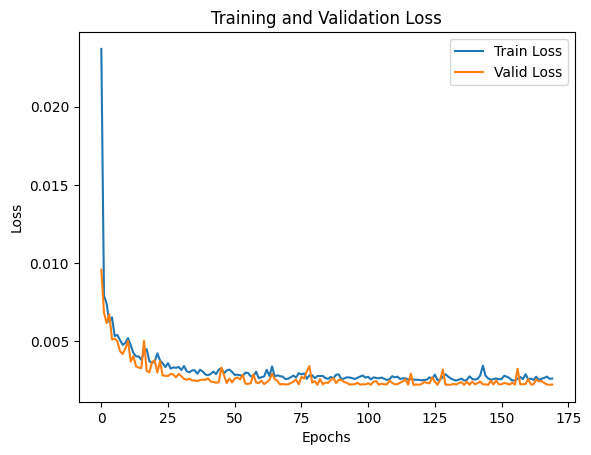

In [22]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Forecasting Using a Simple RNN

In [39]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/200
33/33 [==============================] - 2s 19ms/step - loss: 0.2703 - mae: 0.5615 - val_loss: 0.0690 - val_mae: 0.3274
Epoch 2/200
33/33 [==============================] - 0s 13ms/step - loss: 0.0518 - mae: 0.2654 - val_loss: 0.0394 - val_mae: 0.2189
Epoch 3/200
33/33 [==============================] - 0s 13ms/step - loss: 0.0223 - mae: 0.1578 - val_loss: 0.0163 - val_mae: 0.1460
Epoch 4/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0167 - mae: 0.1627 - val_loss: 0.0162 - val_mae: 0.1387
Epoch 5/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0163 - mae: 0.1563 - val_loss: 0.0159 - val_mae: 0.1379
Epoch 6/200
33/33 [==============================] - 0s 13ms/step - loss: 0.0159 - mae: 0.1559 - val_loss: 0.0155 - val_mae: 0.1377
Epoch 7/200
33/33 [==============================] - 0s 12ms/step - loss: 0.0156 - mae: 0.1559 - val_loss: 0.0152 - val_mae: 0.1371
Epoch 8/200
33/33 [==============================] - 0s 13ms/step - loss: 0.

(<keras.src.callbacks.History at 0x7f1346c925c0>, 102902.21869945526)